In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import time

import models
import flows

In [4]:
data = sio.loadmat("downtream_train_more_data.mat")
x_train = data["x_train"]
y_train = data["y_train"]
f_train = data["f_train"]
xx = data["xx"]
yy = data["yy"]
u_ref = data["u_ref"]
f_ref = data["f_ref"]

#### Bayesian inference with HMC

In [5]:
# load models
mhpinn = models.MHPINN(
    num_tasks=10000, dim=200, name="mhpinn6",
)
mhpinn.restore()
permutation = list(np.arange(101, 201, 1)) + list(np.arange(0, 101, 1))
nf = flows.MAF(
    dim=201,
    permutation=permutation,
    hidden_layers=[100, 100],
    num_bijectors=10,
    activation=tf.nn.relu,
    name="maf",
)
nf.restore()

In [6]:
samples = nf.sample(1000)
xx_test = tf.constant(xx.reshape([-1, 1]), tf.float32)
yy_test = tf.constant(yy.reshape([-1, 1]), tf.float32)

u_samples = mhpinn.call(
    xx_test, yy_test, tf.transpose(samples),
)
f_samples = mhpinn.pde(
    xx_test, yy_test, tf.transpose(samples),
)

u_samples = tf.reshape(u_samples, [101, 101, 1000])
f_samples = tf.reshape(f_samples, [101, 101, 1000])
u_samples = tf.transpose(u_samples, [2, 0, 1])
f_samples = tf.transpose(f_samples, [2, 0, 1])

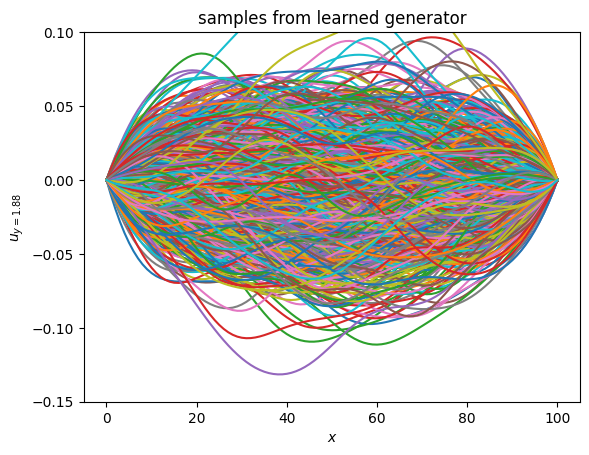

In [7]:
plt.figure(dpi=100)
for i in range(1000):
    plt.plot(u_samples[i, 30, :])
plt.ylim([-0.15, 0.1])
plt.title("samples from learned generator")
plt.ylabel("$u_{y=1.88}$")
plt.xlabel("$x$")
plt.show()

In [8]:
import neuraluq as neuq

Backend is chosen to be the default, tensorflow. You can customize the backend by change it in the 'config.json' file, which can be created or found in your current directory.


In [9]:
class Samplable(neuq.variables._Samplable):
    
    def __init__(self, nf):
        super().__init__()
        self._num_tensors = 1
        self._initial_values = [tf.function(nf.sample)([])]
        self.log_prob_fn = tf.function(nf.log_prob)
    
    def log_prob(self, samples):
        return self.log_prob_fn(samples[0])
    

class Surrogate(neuq.surrogates.Surrogate):
    
    def __init__(self, meta_model):
        self.meta_model = meta_model
        
    def __call__(self, inputs, var_list):
        x, y = tf.split(inputs, 2, axis=-1)
        xi = tf.reshape(var_list[0], [-1, 201])
        return self.meta_model.call(x, y, tf.transpose(xi))
    
    
def pde_fn(inputs, u_fn):
    u = u_fn(inputs)
    u_x, u_y = tf.split(tf.gradients(u, inputs)[0], 2, axis=-1)
    u_xx = tf.gradients(u_x, inputs)[0][:, 0:1]
    u_yy = tf.gradients(u_y, inputs)[0][:, 1:2]
    f = u - u_xx - u_yy
    return f

In [11]:
prior = Samplable(nf)
surrogate = Surrogate(mhpinn)
process = neuq.process.Process(surrogate=surrogate, prior=prior)

likelihood = neuq.likelihoods.Normal(
    inputs=np.concatenate([x_train, y_train], axis=-1), 
    targets=f_train, 
    sigma=0.1, 
    processes=[process],
    equation=pde_fn,
)

model = neuq.models.Model(
    processes=[process], likelihoods=[likelihood],
)

Supporting backend tensorflow



In [12]:
method = neuq.inferences.HMC(
    num_samples=1000,
    num_burnin=1000,
    init_time_step=0.01,
    leapfrog_step=50,
    seed=6666,
)
model.compile(method)

Compiling a MCMC method



In [13]:
t0 = time.time()
samples, results = model.run()
t1 = time.time()
print("Acceptance rate: %.3f \n"%(np.mean(results)))  # if HMC is used
print("Elapsed of HMC: ", t1 - t0)

sampling from posterior distribution ...

Finished sampling from posterior distribution ...

Acceptance rate: 0.666 

Elapsed of HMC:  342.9381968975067


In [14]:
xx_test = tf.constant(xx.reshape([-1, 1]), tf.float32)
yy_test = tf.constant(yy.reshape([-1, 1]), tf.float32)

u_pred = mhpinn.call(xx_test, yy_test, tf.transpose(samples[0])).numpy()
f_pred = mhpinn.pde(xx_test, yy_test, tf.transpose(samples[0])).numpy()
u_pred = u_pred.reshape([101, 101, 1000])
f_pred = f_pred.reshape([101, 101, 1000])

In [15]:
u_mu = np.mean(u_pred, axis=-1)
u_std = np.std(u_pred, axis=-1)

f_mu = np.mean(f_pred, axis=-1)
f_std = np.std(f_pred, axis=-1)

0.5148888858778409


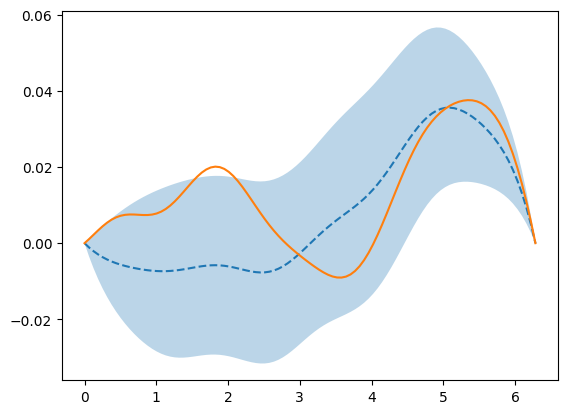

In [16]:
print(
    np.sqrt(np.sum((u_mu - u_ref) ** 2) / np.sum(u_ref ** 2))
)
j = 70
plt.plot(np.linspace(0, 2*np.pi, 101), u_mu[j, :], "--")
plt.plot(np.linspace(0, 2*np.pi, 101), u_ref[j, :])
plt.fill_between(np.linspace(0, 2*np.pi, 101), (u_mu+2*u_std)[j, :], (u_mu-2*u_std)[j, :], alpha=0.3)
plt.show()

In [17]:
u_mu.shape

(101, 101)

In [18]:
u_ref.shape

(101, 101)

0.5148888858778409


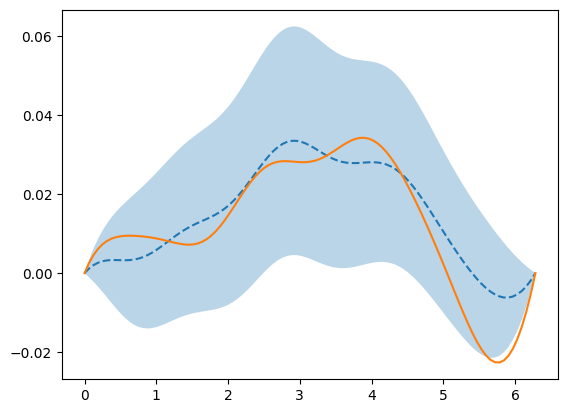

In [19]:
print(np.linalg.norm(u_mu - u_ref, "fro") / np.linalg.norm(u_ref, "fro"))
j = 40
plt.plot(np.linspace(0, 2*np.pi, 101), u_mu[j, :], "--")
plt.plot(np.linspace(0, 2*np.pi, 101), u_ref[j, :])
plt.fill_between(np.linspace(0, 2*np.pi, 101), (u_mu+2*u_std)[j, :], (u_mu-2*u_std)[j, :], alpha=0.3)
plt.show()

0.7619051740322218


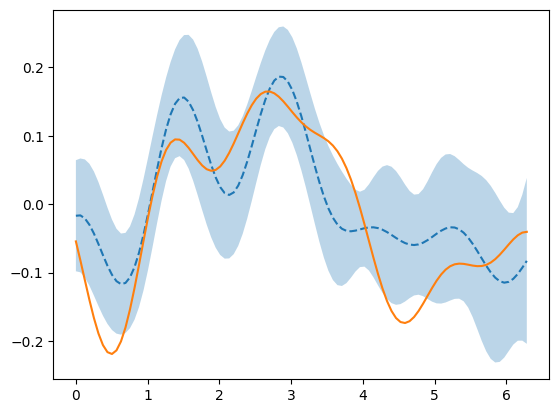

In [20]:
print(np.linalg.norm(f_mu - f_ref, "fro") / np.linalg.norm(f_ref, "fro"))
j = 20
plt.plot(np.linspace(0, 2*np.pi, 101), f_mu[j, :], "--")
plt.plot(np.linspace(0, 2*np.pi, 101), f_ref[j, :])
plt.fill_between(np.linspace(0, 2*np.pi, 101), (f_mu+2*f_std)[j, :], (f_mu-2*f_std)[j, :], alpha=0.3)
plt.show()

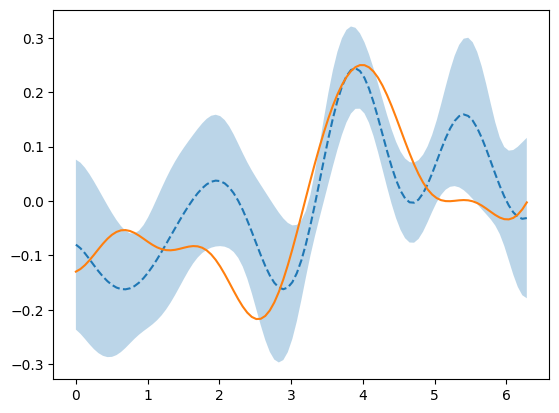

In [21]:
j = 90
plt.plot(np.linspace(0, 2*np.pi, 101), f_mu[:, j], "--")
plt.plot(np.linspace(0, 2*np.pi, 101), f_ref[:, j])
plt.fill_between(np.linspace(0, 2*np.pi, 101), (f_mu+2*f_std)[:, j], (f_mu-2*f_std)[:, j], alpha=0.3)
plt.show()

In [22]:
err = np.abs(f_ref - f_mu)

In [23]:
m = err <= 2*f_std
m = m[1:-1, 1:-1]

In [24]:
np.mean(m)

0.8421589633710845

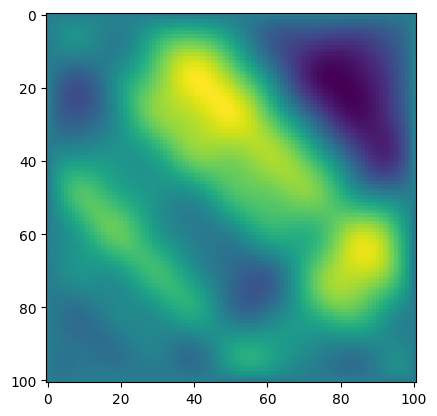

In [23]:
plt.imshow(u_ref)
plt.show()

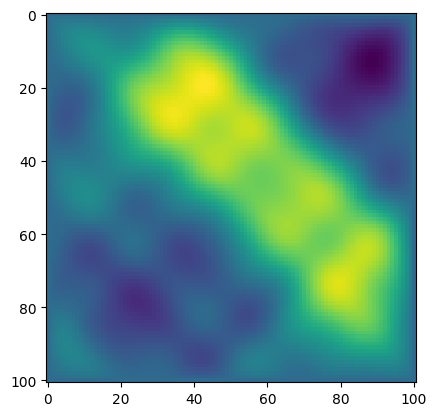

In [24]:
plt.imshow(u_mu)
plt.show()

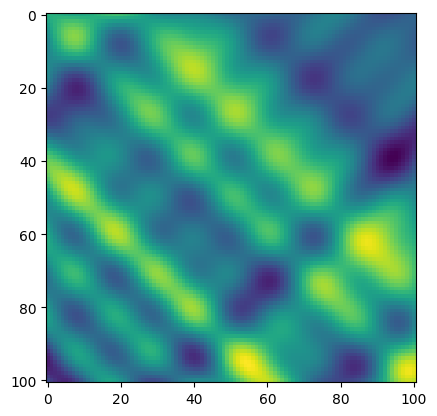

In [25]:
plt.imshow(f_ref)
plt.show()

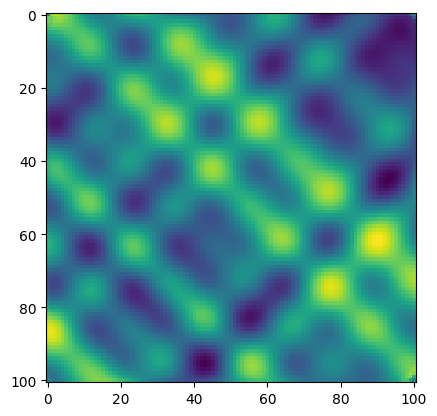

In [26]:
plt.imshow(f_mu)
plt.show()

In [41]:
sio.savemat(
    "hmc.mat",
    {
        "xx": xx, "yy": yy,
        "u_mu": u_mu, "u_std": u_std,
        "f_mu": f_mu, "f_std": f_std,
        "u_ref": u_ref, "f_ref": f_ref,
        "x_train": x_train, "y_train": y_train,
        "f_train": f_train
    }
)

In [ ]:
f_mu.shape

In [ ]:
f_std.shape

In [ ]:
print(np.linalg.norm(f_mu - f_ref, "fro") / np.linalg.norm(f_ref, "fro"))
j = 3
plt.plot(np.linspace(0, 2*np.pi, 101), f_mu[j, :], "--")
plt.plot(np.linspace(0, 2*np.pi, 101), f_ref[j, :])
plt.fill_between(np.linspace(0, 2*np.pi, 101), (f_mu+2*f_std)[j, :], (f_mu-2*f_std)[j, :], alpha=0.3)
plt.show()

In [ ]:
np.argmax(np.abs(f_mu - f_ref))

In [ ]:
f_mu

In [ ]:
f_mu[0, 0]

In [ ]:
f_ref[0, 0]

In [ ]:
np.max(2*f_std)